## Goal: Analyse S&P500 stocks and Ethereum, make predictions and develop a portfolio allocation function

## Data Preparation

### Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf

### Data Import

In [2]:
eth_data = pd.read_excel('ethereum.xlsx', sheet_name=1, skiprows=4)
spx_data = pd.read_csv('spx.csv',  parse_dates=['Date']) # doing the second parameter to already adjust the date type

### EDA & Data Adjustments

1) Ethereum Data

In [3]:
eth_data.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,"Jun 7, 2022",1814.05
1,NaN,"Jun 8, 2022",1793.57
2,NaN,"Jun 9, 2022",1789.83
3,NaN,"Jun 10, 2022",1665.04
4,NaN,"Jun 11, 2022",1529.66


In [4]:
# Dropping the first column of eth_data
eth_data = eth_data.iloc[:, 1:]

# Renaming the columns to what they mean
eth_data.columns = ['Date', 'Price']

eth_data.head()

,Date,Price
0,"Jun 7, 2022",1814.05
1,"Jun 8, 2022",1793.57
2,"Jun 9, 2022",1789.83
3,"Jun 10, 2022",1665.04
4,"Jun 11, 2022",1529.66


In [5]:
eth_data.dtypes

Date      object
Price    float64
dtype: object

In [6]:
# Converting Date column to have appropriate datetime type
eth_data['Date'] = pd.to_datetime(eth_data['Date'])

eth_data.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

In [7]:
eth_data.isna().sum()

Date     0
Price    0
dtype: int64

2) SP500 Data

In [8]:
spx_data.head()

,Date,Close/Last,Open,High,Low
0,2025-02-28,5954.50,5856.74,5959.40,5837.66
1,2025-02-27,5861.57,5981.88,5993.69,5858.78
2,2025-02-26,5956.06,5970.87,6009.82,5932.69
3,2025-02-25,5955.25,5982.73,5992.65,5908.49
4,2025-02-24,5983.25,6026.69,6043.65,5977.83


In [9]:
spx_data.dtypes

Date          datetime64[ns]
Close/Last           float64
Open                 float64
High                 float64
Low                  float64
dtype: object

In [10]:
spx_data.isna().sum()

Date          0
Close/Last    0
Open          0
High          0
Low           0
dtype: int64

3) Further adjustments

In [11]:
# Converting the price columns to DKK
spx_data['Close/Last'] = spx_data['Close/Last'] * 7.10
eth_data['Price'] = eth_data['Price'] * 7.10

In [12]:
# Sorting them both by date
spx_data = spx_data.sort_values(by="Date", ascending=True).reset_index(drop=True) # Redoing the index because it was descending originally
eth_data = eth_data.sort_values(by='Date', ascending=True)

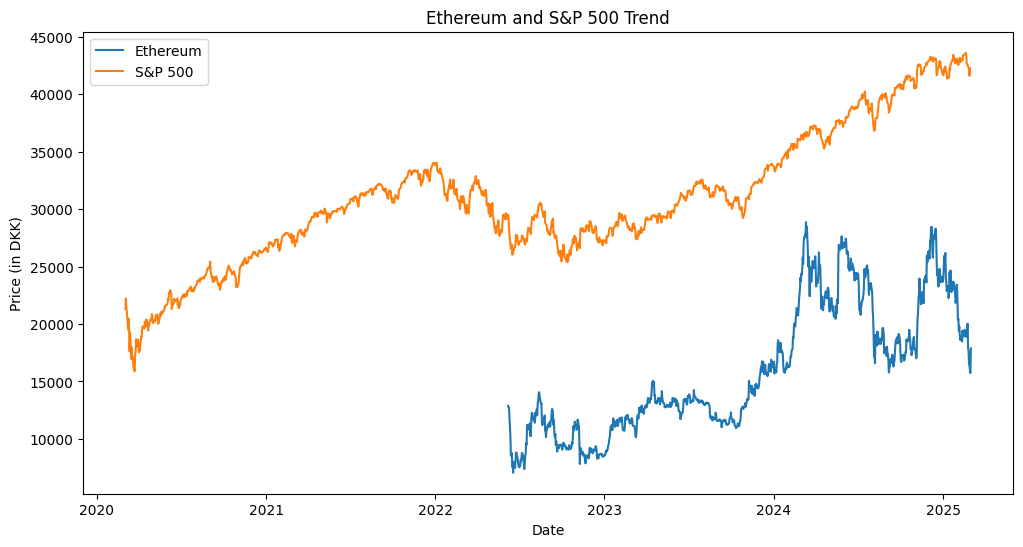

In [13]:
# Plotting and checking the data
plt.figure(figsize=(12, 6))
sns.lineplot(eth_data, x=eth_data['Date'], y=eth_data['Price'], label='Ethereum')
sns.lineplot(spx_data, x=spx_data['Date'], y=spx_data['Close/Last'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Price (in DKK)')
plt.title('Ethereum and S&P 500 Trend')
plt.legend()
plt.show()

In [14]:
# Creating a function to calculate the ROI metric
def calculate_roi(df, start_date, end_date, target):
    
    initial_value = df.loc[df['Date']==start_date, target].values[0]
    final_value = df.loc[df['Date']==end_date, target].values[0]
    
    roi = ((final_value - initial_value) / initial_value) * 100
    
    return roi

In [15]:
### Checking ROI for different time periods

# Time spans we want to look at. These are the last 30 days, 180 days, 365 days, and 998 days of both stocks.
days = [30, 180, 365, 998] # 998 days for "3 years", because that is the max Ethereum timespan

# Creating a list to keep ROI values
spx_roi = []
eth_roi =[]

# Looping for both datasets
for day in days:
    spx_roi.append(calculate_roi(spx_data, spx_data['Date'].iloc[-day], spx_data['Date'].max(), 'Close/Last'))
    
for day in days:
    eth_roi.append(calculate_roi(eth_data, eth_data['Date'].iloc[-day], eth_data['Date'].max(), 'Price'))

# Creating a dataframe for ROIs
df_roi = pd.DataFrame([spx_roi, eth_roi], index=['S&P 500', 'Ethereum'], columns=['1 month', '6 months', '1 year', '3 years'])

df_roi.head()

,1 month,6 months,1 year,3 years
S&P 500,0.289018,10.774800,33.799367,51.154762
Ethereum,-19.197455,2.887325,-27.823053,40.778174


In [16]:
### Creating a new column in both datasets with ROI metric (Return)

# Calculating the ROI you would get within a month for each day
# Last 30 days of each dataframe will have no Return, because data for the future is not available
spx_data['Return'] = float('nan')
eth_data['Return'] = float('nan')

## For S&P 500
# Iterating over index
for idx in range(len(spx_data) - 30): # Avoid out-of-bounds errors
    
    # Getting the dates
    start_date = spx_data['Date'].iloc[idx]
    end_date = spx_data['Date'].iloc[idx + 30]

    # Calculating ROI
    roi = calculate_roi(spx_data, start_date, end_date, 'Close/Last')
    
    # Adding ROI to the column Return
    spx_data.loc[idx, 'Return'] = roi

## For Ethereum
# Iterating over index
for idx in range(len(eth_data) - 30): # Avoid out-of-bounds errors
    
    # Getting dates
    start_date = eth_data['Date'].iloc[idx]
    end_date = eth_data['Date'].iloc[idx + 30]

    # Calculating ROI
    roi = calculate_roi(eth_data, start_date, end_date, 'Price')
    
    # Adding ROI to the column Return
    eth_data.loc[idx, 'Return'] = roi

In [17]:
spx_data.head()

,Date,Close/Last,Open,High,Low,Return
0,2020-03-03,21323.927,3096.46,3136.72,2976.63,-7.325438
1,2020-03-04,22223.852,3045.75,3130.97,3034.38,-10.560937
2,2020-03-05,21469.974,3075.70,3083.04,2999.83,-4.939913
3,2020-03-06,21103.827,2954.20,2985.93,2901.54,-5.019900
4,2020-03-09,19500.576,2863.89,2863.89,2734.43,-0.364092


In [18]:
eth_data.head()

,Date,Price,Return
0,2022-06-07,12879.755,-31.777514
1,2022-06-08,12734.347,-31.839293
2,2022-06-09,12707.793,-32.005833
3,2022-06-10,11821.784,-29.827512
4,2022-06-11,10860.586,-28.269027


As mentioned before, now the data does not have returns for the last 30 observations

In [19]:
spx_data.isna().sum()

Date           0
Close/Last     0
Open           0
High           0
Low            0
Return        30
dtype: int64

In [20]:
eth_data.isna().sum()

Date       0
Price      0
Return    30
dtype: int64

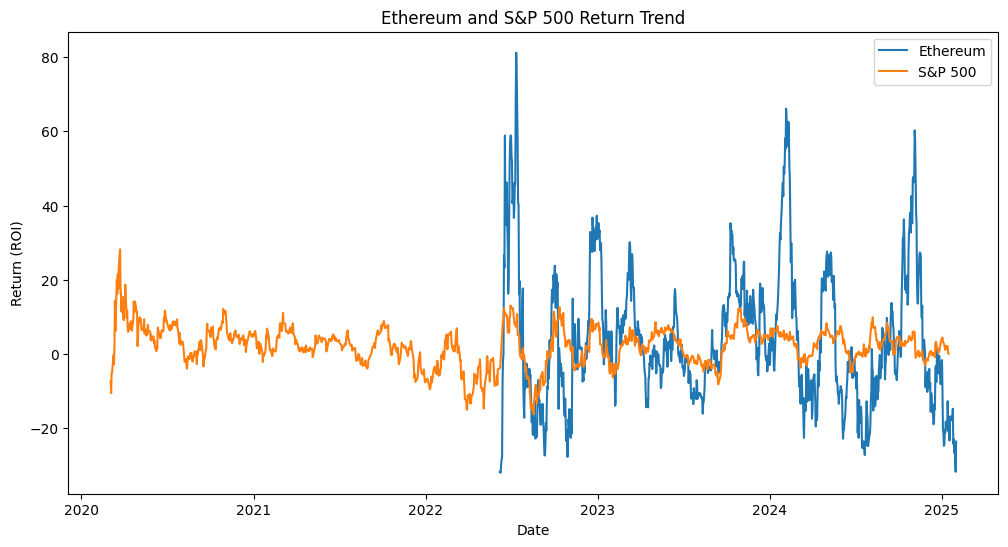

In [21]:
# Creating a plot to visualise the ROI over time
plt.figure(figsize=(12, 6))
sns.lineplot(eth_data, x=eth_data['Date'], y=eth_data['Return'], label='Ethereum')
sns.lineplot(spx_data, x=spx_data['Date'], y=spx_data['Return'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Return (ROI)')
plt.title('Ethereum and S&P 500 Return Trend')
plt.legend()
plt.show()

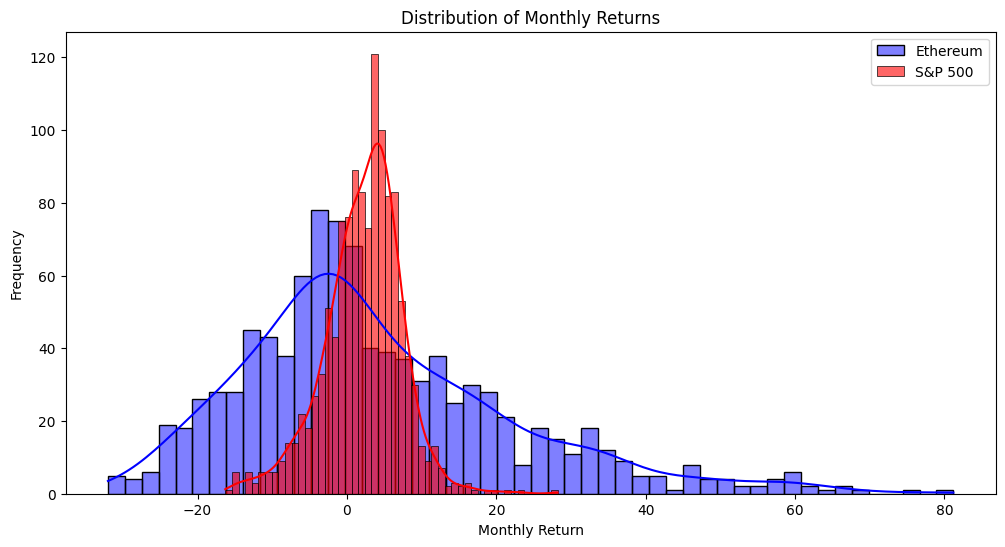

In [22]:
# Creating a histogram plot for both dataset to see the distribution of returns
plt.figure(figsize=(12, 6))
sns.histplot(eth_data['Return'], bins=50, kde=True, color='blue', label='Ethereum')
sns.histplot(spx_data['Return'], bins=50, kde=True, color='red', alpha=0.6, label='S&P 500')
plt.xlabel('Monthly Return')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Returns')
plt.legend()
plt.show()

## Seasonality

<Figure size 3000x1500 with 0 Axes>

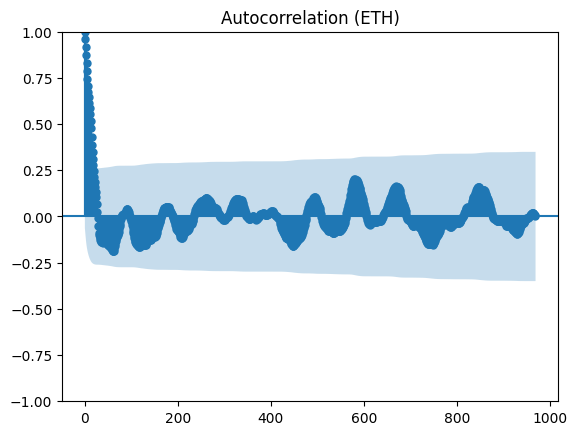

<Figure size 3000x1500 with 0 Axes>

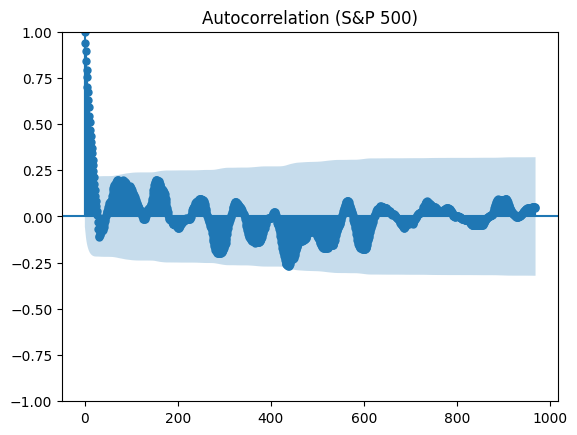

In [23]:
### PLotting the ADF function to have insights on seasonality

plt.figure(figsize=(30,15))
plot_acf(eth_data['Return'].dropna(), lags=969)  # having one lag for each of the days
plt.title("Autocorrelation (ETH)")
plt.show();

plt.figure(figsize=(30,15))
plot_acf(spx_data['Return'].dropna(), lags=969)
plt.title("Autocorrelation (S&P 500)")
plt.show();

Both data sets show some kind of reoccuring pattern in the ACF plot, but the peaks are all within the confidence interval (light blue shaded area) and thus statistically insignificant. This implies possible patterns, but no true seasonality. We argue that there is no seasonality within those data sets.

## Machine Learning for Future Value Predictions

In [24]:
# Dropping the null values as we still had them from the return calculation
spx_data.dropna(inplace=True)
eth_data.dropna(inplace=True)

In [25]:
# Preparing the data for regression by computing the number of days since the first recorded date to use as a feature
eth_data['Days'] = (eth_data['Date'] - eth_data['Date'].min()).dt.days
spx_data['Days'] = (spx_data['Date'] - spx_data['Date'].min()).dt.days

Support Vector Regression will be used for this matter

In [26]:
# Preparing the data
X_sp500 = spx_data[["Days"]]
y_sp500 = spx_data["Return"]
X_train_sp500, X_test_sp500, y_train_sp500, y_test_sp500 = train_test_split(X_sp500, y_sp500, test_size=0.2, shuffle=False)

X_eth = eth_data[["Days"]]
y_eth = eth_data["Return"]
X_train_eth, X_test_eth, y_train_eth, y_test_eth = train_test_split(X_eth, y_eth, test_size=0.2, shuffle=False)

In [27]:
# Scalling the data
scaler_X = StandardScaler()
scaler_sp500 = StandardScaler()
scaler_eth = StandardScaler()

# Doing that for SP500
X_train_scaled_sp500 = scaler_X.fit_transform(X_train_sp500)
X_test_scaled_sp500 = scaler_X.transform(X_test_sp500)
y_train_sp500_scaled = scaler_sp500.fit_transform(y_train_sp500.values.reshape(-1, 1))
y_test_sp500_scaled = scaler_sp500.transform(y_test_sp500.values.reshape(-1, 1))

# Doing that for Ethereum
X_train_scaled_eth = scaler_X.fit_transform(X_train_eth)
X_test_scaled_eth = scaler_X.transform(X_test_eth)
y_train_ethereum_scaled = scaler_eth.fit_transform(y_train_eth.values.reshape(-1, 1))
y_test_ethereum_scaled = scaler_eth.transform(y_test_eth.values.reshape(-1, 1))

In [28]:
# Initialising the SVR model
# RBf Kernel for non linear data
# C --> Less regularization so data fits the training data more precisly, which is in this case quite important
# Low gamme to catch global trends --> moderate influence of each data point
# Low epsilon for trying to fit closely
SVR_sp500 = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
SVR_eth = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# Fitting the data
SVR_sp500.fit(X_train_scaled_sp500, y_train_sp500_scaled.ravel()) # ravel() ensures that this is a 1 dimensional array --> SVR needs 1D target array
SVR_eth.fit(X_train_scaled_eth, y_train_ethereum_scaled.ravel())

# Doing the predictions
y_pred_sp500_scaled = SVR_sp500.predict(X_test_scaled_sp500)
y_pred_eth_scaled = SVR_eth.predict(X_test_scaled_eth)

# Rescalling the data
y_pred_sp500 = scaler_sp500.inverse_transform(y_pred_sp500_scaled.reshape(-1, 1))
y_pred_eth = scaler_eth.inverse_transform(y_pred_eth_scaled.reshape(-1, 1))

In [29]:
# Checking MSE of both
mse_sp500 = mean_squared_error(y_test_sp500, y_pred_sp500)
mse_ethereum = mean_squared_error(y_test_eth, y_pred_eth)

print(f'Mean Squared Error of the SVR model for SP500: {mse_sp500}')
print(f'Mean Squared Error of the SVR model for Ethereum: {mse_ethereum}')

Mean Squared Error of the SVR model for SP500: 27.84265833737784
Mean Squared Error of the SVR model for Ethereum: 3677.015635148714


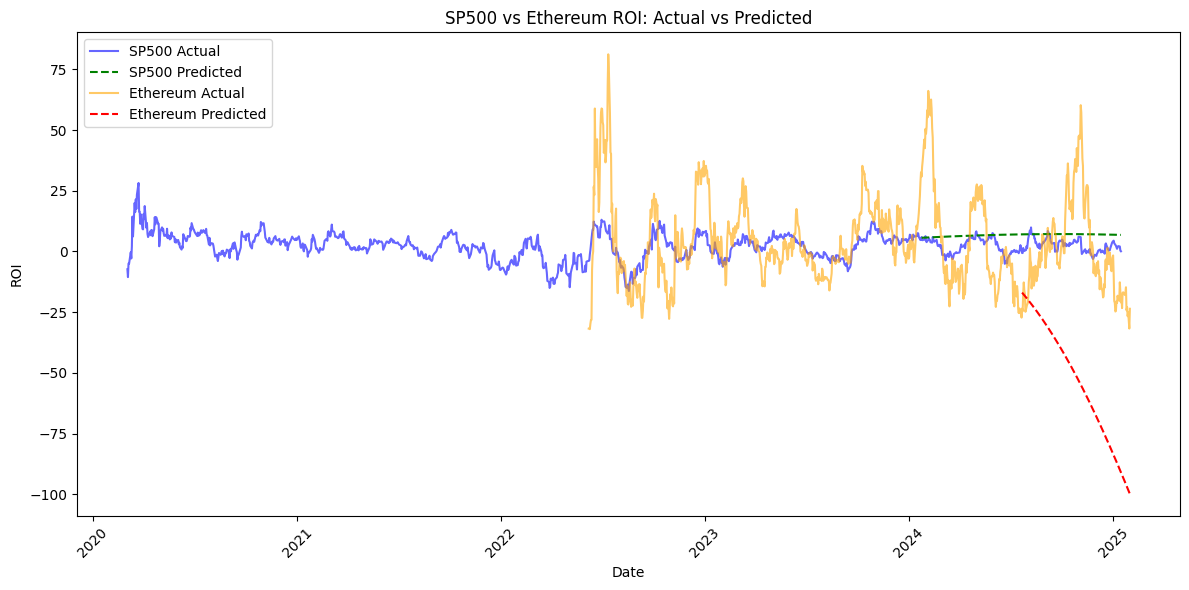

In [30]:
### Plotting everything
plt.figure(figsize=(12, 6))

# SP500
plt.plot(spx_data["Date"], spx_data["Return"], label="SP500 Actual", color="blue", alpha=0.6)
plt.plot(spx_data["Date"].iloc[-len(y_pred_sp500):], y_pred_sp500, label="SP500 Predicted", color="green", linestyle="dashed")

# Ethereum
plt.plot(eth_data["Date"], eth_data["Return"], label="Ethereum Actual", color="orange", alpha=0.6)
plt.plot(eth_data["Date"].iloc[-len(y_pred_eth):], y_pred_eth, label="Ethereum Predicted", color="red", linestyle="dashed")

# Adding titles and labels
plt.title('SP500 vs Ethereum ROI: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('ROI')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Predictions

In [31]:
### Adding the same number of days for both X test dfs

# Checking max dates
max_date_sp500 = spx_data["Date"].max()
max_date_eth = eth_data["Date"].max()

print(f"SP500 Max Date - {max_date_sp500}. ETH Max Date - {max_date_eth}")

SP500 Max Date - 2025-01-15 00:00:00. ETH Max Date - 2025-01-31 00:00:00


In [32]:
# ETH has more recent data - let's calculate the difference
date_diff = max_date_eth - max_date_sp500

print(f"The difference is {date_diff.days} days.")

The difference is 16 days.


In [33]:
# Generating the future features to use in predictions
def create_pred_X(last_day, days_prediction):
    numbers = [last_day + 1 + i for i in range(days_prediction)]
    df = pd.DataFrame(numbers, columns=["Days"])
    return df

# Here we set our prediction timespan
days_prediction = 730

X_sp500_pred = create_pred_X(spx_data["Days"].max(), days_prediction+date_diff.days)
X_eth_pred = create_pred_X(eth_data["Days"].max(), days_prediction)

In [34]:
# Scaling data
X_pred_scaled_sp500 = scaler_X.fit_transform(X_sp500_pred)
X_pred_scaled_eth = scaler_X.fit_transform(X_eth_pred)

# Predicting
y_pred_sp500_scaled = SVR_sp500.predict(X_pred_scaled_sp500)
y_pred_eth_scaled = SVR_eth.predict(X_pred_scaled_eth)

# Rescalling the data
y_pred_sp500 = scaler_sp500.inverse_transform(y_pred_sp500_scaled.reshape(-1, 1))
y_pred_eth = scaler_eth.inverse_transform(y_pred_eth_scaled.reshape(-1, 1))

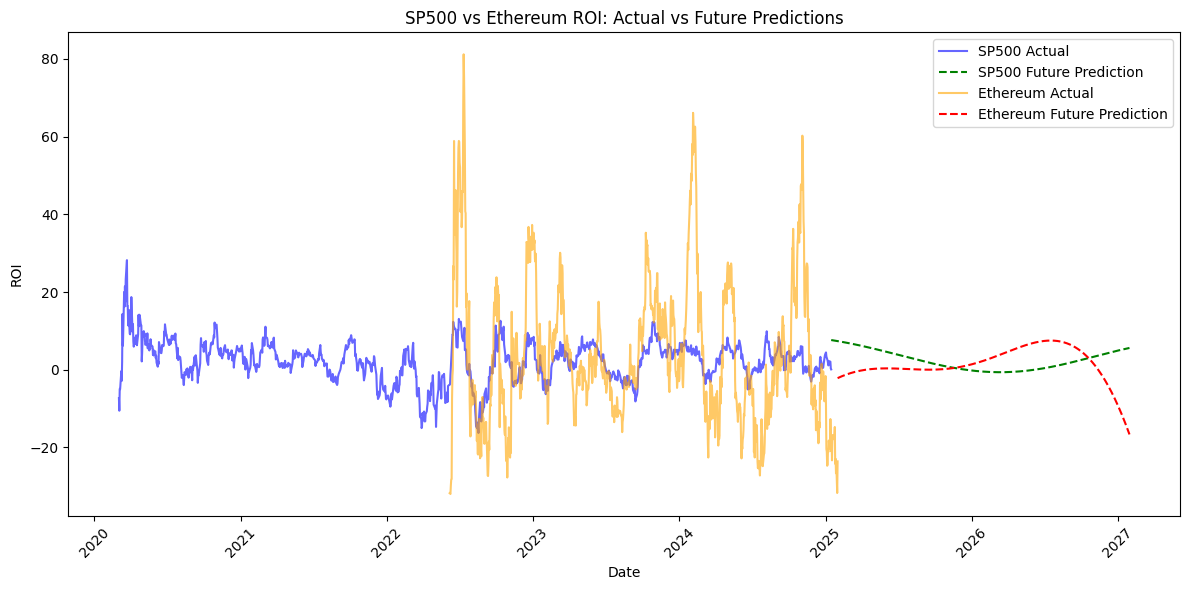

In [35]:
# Plotting the results
plt.figure(figsize=(12, 6))

# SP500 Predictions
plt.plot(spx_data["Date"], spx_data["Return"], label="SP500 Actual", color="blue", alpha=0.6)
plt.plot(pd.date_range(start=spx_data["Date"].iloc[-1], periods=(days_prediction+16), freq='D'),
         y_pred_sp500, label="SP500 Future Prediction", color="green", linestyle="dashed")

# Ethereum Predictions
plt.plot(eth_data["Date"], eth_data["Return"], label="Ethereum Actual", color="orange", alpha=0.6)
plt.plot(pd.date_range(start=eth_data["Date"].iloc[-1], periods=days_prediction, freq='D'),
         y_pred_eth, label="Ethereum Future Prediction", color="red", linestyle="dashed")

# Titles and Labels
plt.title('SP500 vs Ethereum ROI: Actual vs Future Predictions')
plt.xlabel('Date')
plt.ylabel('ROI')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Portfolio based on prediction

In [36]:
### Let's say we want to compute allocations every 3 months

# Defining the 3-month interval
rolling_window = 90

# Looping through predicted time interval with 3-month step
for i in range(0, len(y_pred_sp500) - rolling_window, rolling_window):
    # Select the current prediction window
    spx_window = y_pred_sp500[i:i+rolling_window]
    eth_window = y_pred_eth[i:i+rolling_window]

    # Computing expected returns for each asset
    spx_exp_return = max(0, spx_window.mean())  # Using MAX function to ensure non-negative return
    eth_exp_return = max(0, eth_window.mean())

    # Allocating weights proportionally
    total_return = spx_exp_return + eth_exp_return

    if total_return > 0:  # Having this conditional to avoid division by zero
        spx_weight = spx_exp_return / total_return
        eth_weight = eth_exp_return / total_return
    else:
        spx_weight, eth_weight = 0.5, 0.5  # Making it equal allocation if both returns are zero

    # Getting corresponding date
    day = X_sp500_pred.iloc[i]['Days']
    date = spx_data['Date'].max() + pd.to_timedelta(day - X_sp500_pred['Days'].min(), unit='D')

    # Printing the allocation with the date to start this allocation
    print(f'Date: {date}')
    print(f'S&P 500 Allocation: {spx_weight:.2%}')
    print(f'Ethereum Allocation: {eth_weight:.2%}')
    print('-' * 40)


Date: 2025-01-15 00:00:00
S&P 500 Allocation: 100.00%
Ethereum Allocation: 0.00%
----------------------------------------
Date: 2025-04-15 00:00:00
S&P 500 Allocation: 94.41%
Ethereum Allocation: 5.59%
----------------------------------------
Date: 2025-07-14 00:00:00
S&P 500 Allocation: 97.56%
Ethereum Allocation: 2.44%
----------------------------------------
Date: 2025-10-12 00:00:00
S&P 500 Allocation: 27.66%
Ethereum Allocation: 72.34%
----------------------------------------
Date: 2026-01-10 00:00:00
S&P 500 Allocation: 0.00%
Ethereum Allocation: 100.00%
----------------------------------------
Date: 2026-04-10 00:00:00
S&P 500 Allocation: 0.00%
Ethereum Allocation: 100.00%
----------------------------------------
Date: 2026-07-09 00:00:00
S&P 500 Allocation: 20.60%
Ethereum Allocation: 79.40%
----------------------------------------
Date: 2026-10-07 00:00:00
S&P 500 Allocation: 100.00%
Ethereum Allocation: 0.00%
----------------------------------------
